# 台北捷運客流量分析

## 一、定義問題與目標
捷運和共享單車是两种交通工具，各有其特點和作用。捷運作為一種大眾交通工具，可以高效地把人們運送到較遠的地方，讓人們在城市不同區域快速穿梭。共享單車是一種輕便、經濟、環保的交通工具，尤其是在較短的路程或人口稠密的區域內。兩者配合使用可以提供更加彈性、方便、經濟的出行體驗。譬如可以先乘坐捷運到達目的地附近的捷運站，然後騎共享單車前往目的地附近的停車樁。又或者可以先騎共享單車前往捷運站，然後乘坐捷運前往目的地。

共享單車的設置和捷運位置及客流量非常相關，共享單車應該要放在公共交通枢纽、商業區、學校和住宅區等區域附近，這些地方通常有較多的人流量，可以提供更多的出行需求。但是究竟哪些捷運站點有較多的客流量，以及這些捷運站的客流週期為何，什麼時間點有較大的客流量，什麼時間點有較小的客流量，以及是否能夠預測未來的客流量，這些問題的釐清可以幫助共享單車營運業者做出更好的決策。因此本文希望藉由台北捷運客流量的公開資料集，分析台北捷運客流量的整體趨勢和週期，以及客流量較大的捷運站點和路線，挖掘規律和變化，檢測客流量異常的狀況，並嘗試解釋過去和預測未來，輔助共享單車業者進行車輛調度的營運決策制定，從而提供更彈性和高效的出行體驗。

## 二、資料準備

In [1]:
!pip install pandas_ods_reader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 31.3 MB/s 
  Created wheel for ezodf: filename=ezodf-0.3.2-py2.py3-none-any.whl size=49002 sha256=9c0cc6659cdcd6d4a0e9251571cf751fbbc05626467541904330655658f65fab
  Stored in directory: /root/.cache/pip/wheels/50/d3/91/67b352fa0847576d7f3716a1d9a8ded88abb49e6c972cec44a
Successfully built ezodf


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
from pandas_ods_reader import read_ods
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os
import re
import random
import datetime
import requests
from bs4 import BeautifulSoup as bs
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.api as smt 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings  
warnings.filterwarnings("ignore")

In [4]:
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
import matplotlib as mpl
from matplotlib.font_manager import fontManager
fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')
plt.rcParams['font.sans-serif'] = ['SimHei']

--2022-12-28 14:52:26--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 172.217.193.102, 172.217.193.138, 172.217.193.100, ...
Connecting to drive.google.com (drive.google.com)|172.217.193.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5kl9pa4s3tpa66qkbklnn3h8tj82bn8c/1672239075000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=892a7ac3-6f19-4489-85aa-2d69ff0d1954 [following]
--2022-12-28 14:52:29--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5kl9pa4s3tpa66qkbklnn3h8tj82bn8c/1672239075000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=892a7ac3-6f19-4489-85aa-2d69ff0d1954
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 142.250.97.132, 2607:f8b0:400c:c18::84
Connecting to do

### 2.1 下載資料
撰寫爬蟲程式批量下載資料集

資料來源：https://www.metro.taipei/cp.aspx?n=FF31501BEBDD0136


In [5]:
# url = 'https://www.metro.taipei/cp.aspx?n=FF31501BEBDD0136'
# res = requests.get(url, verify=False)
# res.encoding = 'utf-8'
# soup = bs(res.text, 'html.parser')

# folder = 'metro_cn'
# if not os.path.exists(folder):
#     os.mkdir(folder)
# # for ele in soup.find_all('a', {'title': re.compile('^Ridership')})[1:4]:
# for ele in soup.find_all('a', {'class': 'ods link'}):
#     url = ele['href']
#     print(url)
#     os.system(f'wget -P {folder} {url}')

### 2.2 載入資料 & 資料預處理

In [6]:
# # 進站資料
# entry_total = pd.DataFrame()
# for path in glob('/content/drive/MyDrive/datasets/metro_cn/*.ods'):
#     entry_one = read_ods(path , '進站資料')
#     entry_one.rename(columns = {entry_one.columns[0]: "日期"}, inplace=True)
#     entry_one['日期'] = pd.to_datetime(entry_one['日期'])
#     entry_total = entry_total.append(entry_one, ignore_index=True)
# entry_total['板橋NEW'] = np.nansum(entry_total[['板橋','Y板橋','BL板橋']], axis=1)
# entry_total['台北101/世貿'] = np.nansum(entry_total[['台北101/世貿','台北101/世貿中心']], axis=1)
# entry_total.drop(columns=['板橋','Y板橋','BL板橋','台北101/世貿中心'], axis=1, inplace=True)
# entry_total.set_index('日期', inplace = True)
# entry_total.sort_index(inplace = True)
# entry_total = entry_total[:-9]
# entry_total.fillna(0, inplace=True)
# entry_total = entry_total.astype(int)

# entry_addfeature = entry_total.copy()
# entry_addfeature.reset_index(inplace=True)
# entry_addfeature['總客流量'] = entry_addfeature.sum(axis=1)
# entry_addfeature['年'] = entry_addfeature['日期'].apply(lambda x: datetime.datetime.strftime(x, '%Y')).astype('int64')
# entry_addfeature['月'] = entry_addfeature['日期'].apply(lambda x: datetime.datetime.strftime(x, '%m')).astype('int64')
# entry_addfeature['周'] = entry_addfeature['日期'].apply(lambda x: datetime.datetime.strftime(x, '%w')).astype('int64')
# entry_addfeature.set_index('日期', inplace = True)
# entry_addfeature.sort_index(inplace = True)
# entry_addfeature = entry_addfeature.astype(int)

In [7]:
# entry_total.to_csv('/content/drive/MyDrive/datasets/metro_entry_total.csv', encoding='utf-8')
# entry_addfeature.to_csv('/content/drive/MyDrive/datasets/metro_entry_addfeature.csv', encoding='utf-8')

In [4]:
entry_total = pd.read_csv('/content/drive/MyDrive/datasets/metro_entry_total.csv')
entry_total['日期'] = pd.to_datetime(entry_total['日期'])
entry_total.set_index('日期', inplace=True)

entry_addfeature = pd.read_csv('/content/drive/MyDrive/datasets/metro_entry_addfeature.csv')
entry_addfeature['日期'] = pd.to_datetime(entry_addfeature['日期'])
entry_addfeature.set_index('日期', inplace=True)

In [9]:
# # 出站資料
# exit_total = pd.DataFrame()
# for path in glob('/content/drive/MyDrive/datasets/metro_cn/*.ods'):
#     exit_one = read_ods(path , '出站資料')
#     exit_one.rename(columns = {exit_one.columns[0]: "日期"}, inplace=True)
#     exit_one['日期'] = pd.to_datetime(exit_one['日期'])
#     exit_total = exit_total.append(exit_one, ignore_index=True)
# exit_total.fillna(0, inplace=True)
# exit_total['板橋NEW'] = exit_total['板橋'] + exit_total['Y板橋'] + exit_total['BL板橋']
# exit_total['台北101/世貿'] = exit_total['台北101/世貿'] + exit_total['台北101/世貿中心']
# exit_total.drop(columns=['板橋','Y板橋','BL板橋','台北101/世貿中心'], axis=1, inplace=True)

# exit_addfeature = exit_total.copy()
# exit_addfeature['總客流量'] = exit_addfeature.sum(axis=1)
# exit_addfeature['年'] = exit_addfeature['日期'].apply(lambda x: datetime.datetime.strftime(x, '%Y')).astype('int64')
# exit_addfeature['月'] = exit_addfeature['日期'].apply(lambda x: datetime.datetime.strftime(x, '%m')).astype('int64')
# exit_addfeature['周'] = exit_addfeature['日期'].apply(lambda x: datetime.datetime.strftime(x, '%w')).astype('int64')
# exit_addfeature.set_index('日期', inplace = True)
# exit_addfeature.sort_index(inplace = True)
# exit_addfeature = exit_addfeature.astype(int)

# exit_total.set_index('日期', inplace = True)
# exit_total.sort_index(inplace = True)
# exit_total = exit_total.astype(int)

In [10]:
# exit_total.to_csv('/content/drive/MyDrive/datasets/metro_exit_total.csv', encoding='utf-8')
# exit_addfeature.to_csv('/content/drive/MyDrive/datasets/metro_exit_addfeature.csv', encoding='utf-8')

In [11]:
exit_total = pd.read_csv('/content/drive/MyDrive/datasets/metro_exit_total.csv')
exit_total['日期'] = pd.to_datetime(exit_total['日期'])
exit_total.set_index('日期', inplace=True)

exit_addfeature = pd.read_csv('/content/drive/MyDrive/datasets/metro_exit_addfeature.csv')
exit_addfeature['日期'] = pd.to_datetime(exit_addfeature['日期'])
exit_addfeature.set_index('日期', inplace=True)

## 三、EDA 分析

### 3.1 出站客流量: 趨勢分析
疫情前幾年，客流量長期處於逐年緩步上升的態勢。疫情確實給捷運帶來巨大的挑戰，但是最嚴重的還不是疫情剛開始爆發的時候，而是在2021年5、6月的時候疫情再次大爆發，全部啟動居家上班的政策，客流量跌了80%。爾後同樣在2022年5月時疫情再次爆發，但跌幅沒有2021年那麼大，之後逐漸恢復到疫情前的水平。

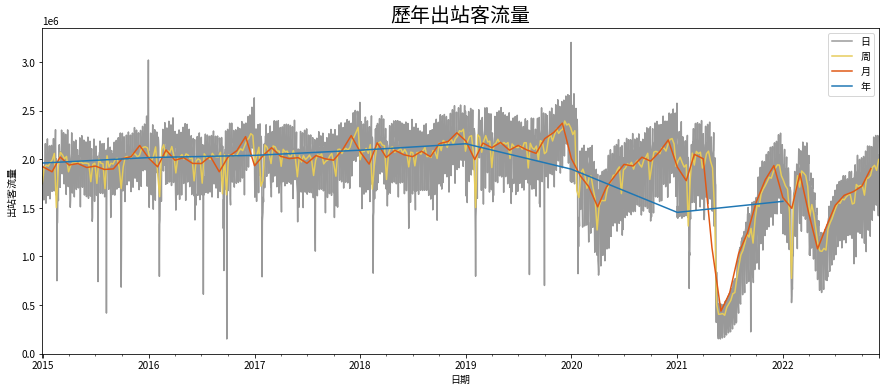

In [12]:
plt.figure(figsize=(15,6))
exit_addfeature['總客流量'].plot(color='#999999', label='日')
exit_addfeature['總客流量'].resample('W').mean().plot(color='#E6CC5A', label='周')
exit_addfeature['總客流量'].resample('M').mean().plot(color='#E05814', label='月')
exit_addfeature['總客流量'].resample('Y').mean().plot(label='年')
plt.title('歷年出站客流量', fontsize=20)
plt.ylabel('出站客流量')
plt.legend()

### 3.2 出站客流量: 週期性分析
使用移動平均線對時間序列資料進行季節性分解，可以分離出長期趨勢和季節趨勢。可以發現客流量存在明顯的週期性，在年底達到高峰，春節期間會有一次明顯下滑，年中也有一次明顯的下滑。

(735599.0, 738521.0)

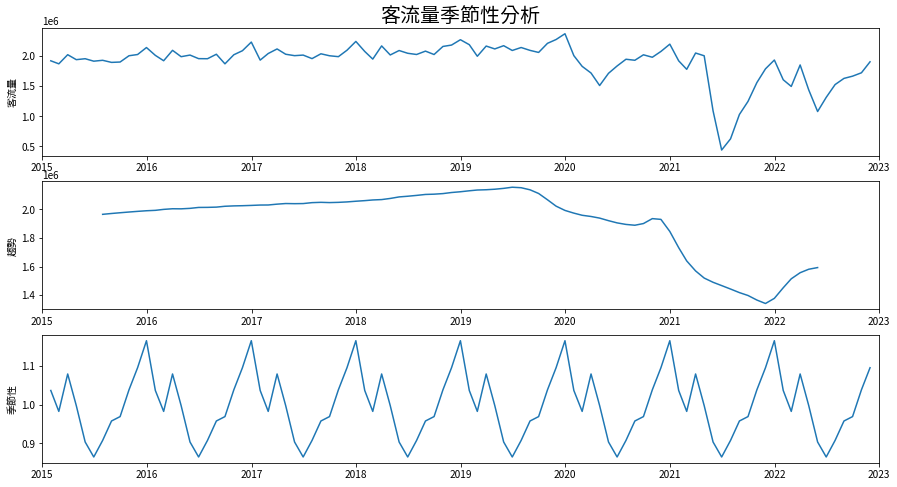

In [15]:
sample = exit_addfeature['總客流量'].resample('M').mean()
result = seasonal_decompose(sample, model='multiplicative', freq=12)
plt.figure(figsize=(15,8))
plt.subplot(3,1,1)
plt.plot(result.observed)
plt.title('客流量季節性分析', fontsize=20)
plt.ylabel('客流量')
plt.xlim(np.datetime64('2015'), np.datetime64('2023'))

plt.subplot(3,1,2)
plt.plot(result.trend)
plt.ylabel('趨勢')
plt.xlim(np.datetime64('2015'), np.datetime64('2023'))

plt.subplot(3,1,3)
plt.plot(result.seasonal)
plt.ylabel('季節性')
plt.xlim(np.datetime64('2015'), np.datetime64('2023'))

因為疫情影響，個別月份客流量下降顯著。單純看所有年份的每月平均客流量，已經失真，需要區分疫情前後進行研究。

(0.0, 2300000.0)

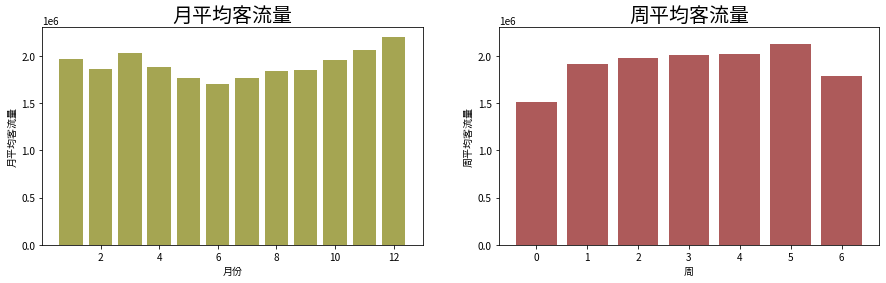

In [16]:
plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
mon_avg = exit_addfeature.groupby('月').mean()['總客流量']
plt.bar(mon_avg.index, mon_avg, color='#A5A552')
plt.title('月平均客流量', fontsize=20)
plt.xlabel('月份')
plt.ylabel('月平均客流量')
plt.ylim(0, 2300000)

plt.subplot(1, 2, 2)
week_avg = exit_addfeature.groupby('周').mean()['總客流量']
plt.bar(week_avg.index, week_avg, color='#AD5A5A')
plt.title('周平均客流量', fontsize=20)
plt.xlabel('周')
plt.ylabel('周平均客流量')
plt.ylim(0, 2300000)

疫情前後的周平均客流量對比，客流量明顯下降，但趨勢不變。客流量在周五達到高峰，周日最低。

(0.0, 2300000.0)

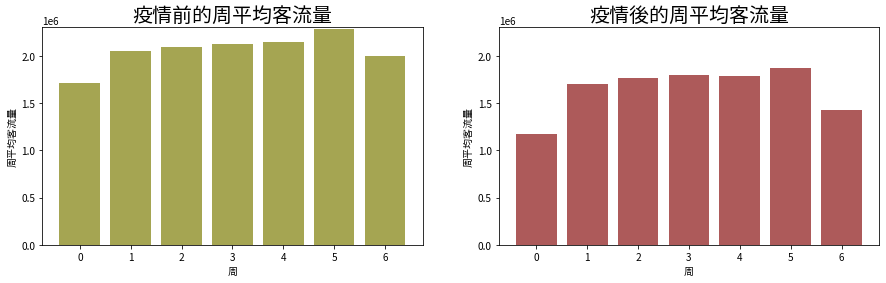

In [17]:
plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
week_avg = exit_addfeature[:'2019'].groupby('周').mean()['總客流量']
plt.bar(week_avg.index, week_avg, color='#A5A552')
plt.title('疫情前的周平均客流量', fontsize=20)
plt.xlabel('周')
plt.ylabel('周平均客流量')
plt.ylim(0, 2300000)

plt.subplot(1, 2, 2)
week_avg = exit_addfeature['2020':].groupby('周').mean()['總客流量']
plt.bar(week_avg.index, week_avg, color='#AD5A5A')
plt.title('疫情後的周平均客流量', fontsize=20)
plt.xlabel('周')
plt.ylabel('周平均客流量')
plt.ylim(0, 2300000)

疫情前後的月平均客流量對比。客流量在12月和1月達到頂峰，2月明顯下降。

(0.0, 2300000.0)

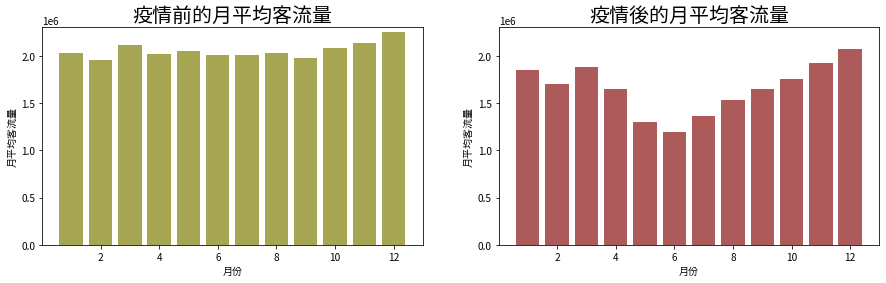

In [18]:
plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
mon_avg = exit_addfeature[:'2019'].groupby('月').mean()['總客流量']
plt.bar(mon_avg.index, mon_avg, color='#A5A552')
plt.title('疫情前的月平均客流量', fontsize=20)
plt.xlabel('月份')
plt.ylabel('月平均客流量')
plt.ylim(0, 2300000)

plt.subplot(1, 2, 2)
mon_avg = exit_addfeature['2020':].groupby('月').mean()['總客流量']
plt.bar(mon_avg.index, mon_avg, color='#AD5A5A')
plt.title('疫情後的月平均客流量', fontsize=20)
plt.xlabel('月份')
plt.ylabel('月平均客流量')
plt.ylim(0, 2300000)

季節效應：12月聖誕節和跨年晚會，人潮最多；2月農曆春節，民眾返鄉，運量來到低點

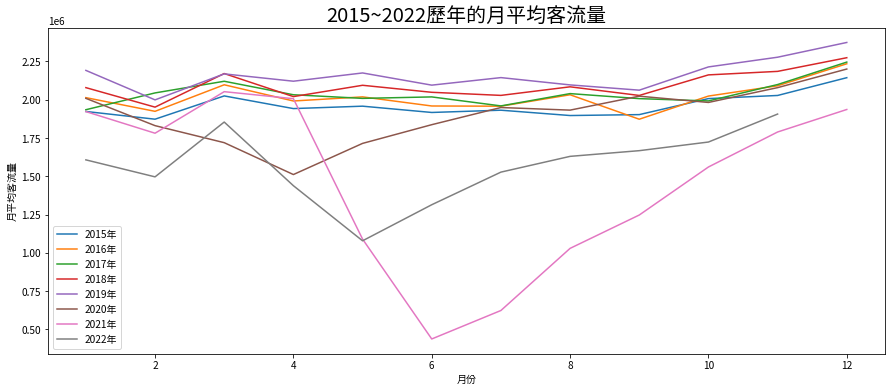

In [19]:
plt.figure(figsize=(15,6))
years = list(exit_addfeature['年'].unique())
for year in years:
    plt.plot(exit_addfeature[f'{year}'].groupby('月').mean()['總客流量'], label=f'{year}年')
plt.title('2015~2022歷年的月平均客流量', fontsize=20)
plt.xlabel('月份')
plt.ylabel('月平均客流量') 
plt.legend()

### 3.3 出站客流量: 異常分析

以2019年出站客流量為例，2月、8月、10月分別有一次明顯的下滑，而12月底有明顯的上升。對比當年的事紀可以發現：
- 2019年2月2~2月10日，為農曆春節假期；
- 2019年8月8~8月9日，氣象局針對颱風「利奇馬」發布颱風警報；
- 2019年9月30~10月1日，氣象局針對颱風「米塔」發布颱風警報。
- 2019年12/24日為平安夜，2019年12/31~2020年1/1為跨年活動。

因此可以推估為: **農曆春節**和**颱風**會影響捷運客流量急劇下滑，**聖誕節平安夜**和**跨年活動**會影響客流量急遽攀升。

Text(0, 0.5, '出站客流量')

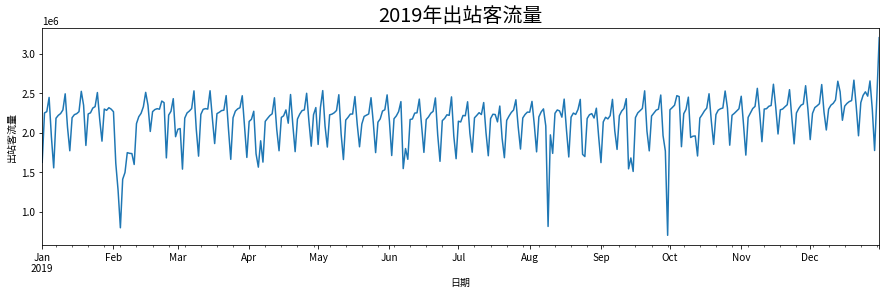

In [13]:
plt.figure(figsize=(15,4))
exit_addfeature['2019']['總客流量'].plot()
plt.title('2019年出站客流量', fontsize=20)
plt.ylabel('出站客流量')

模仿股票技術分析方法，繪製出以30日均線和上下兩倍標準差的布林帶。假設資料符合常態分佈，那麼兩倍標準差的範圍可以覆蓋到95.45%的情況，所以當客流量超出該範圍的時候，可以發出異常警告。

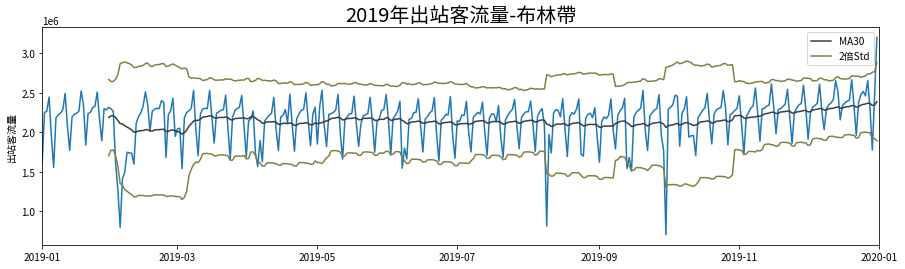

In [14]:
plt.figure(figsize=(15,4))
exit2019 = exit_addfeature['2019']
exit2019['ma'] = exit2019['總客流量'].rolling(window=30).mean()
exit2019['std'] = exit2019['總客流量'].rolling(window=30).std()
# 計算布林帶
exit2019['upper'] = exit2019['ma'] + 2 * exit2019['std']
exit2019['lower'] = exit2019['ma'] - 2 * exit2019['std']
# 繪製布林帶圖
plt.plot(exit2019['總客流量'])
plt.plot(exit2019['ma'], color='#3C3C3C', label='MA30')
plt.plot(exit2019['upper'], color='#808040', label='2倍Std')
plt.plot(exit2019['lower'], color='#808040')
plt.xlim(np.datetime64('2019-01'), np.datetime64('2020-01'))
plt.title('2019年出站客流量-布林帶', fontsize=20)
plt.ylabel('出站客流量')
plt.legend()
plt.show()

### 3.4 出站客流量: Top 10捷運站變化分析
- 台北車站和市政府一直都是重要的交通樞紐，客流量排名前列；
- 板橋作為新的交通樞紐，客流量有上升的態勢；
- 西門從2020年開始從第二名滑落到第三名；
- 忠孝敦化所代表的東區，基本處於客流量逐年下滑的態勢，甚至掉出前十名之列，可以反映東區沒落、人潮下降；
- 中山站逆勢崛起，客流量有上升的態勢，擠進前五名，成為熱門商圈

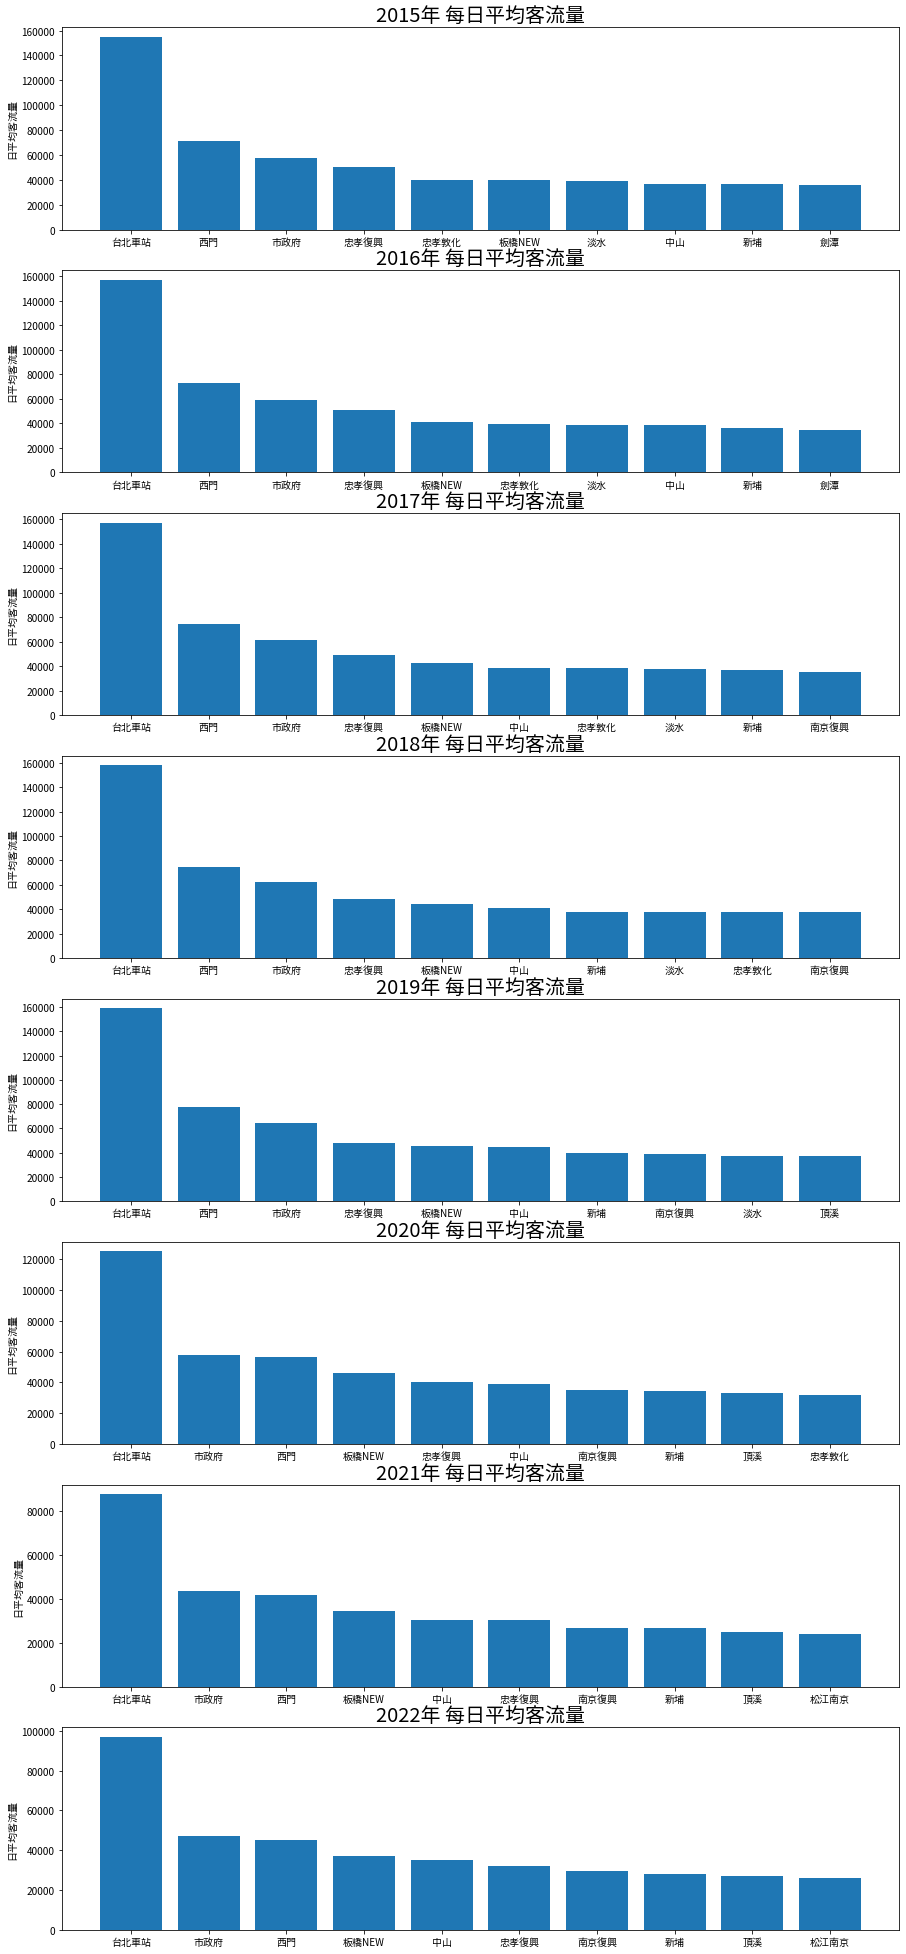

In [20]:
plt.figure(figsize=(15,35))
years = list(exit_addfeature['年'].unique())
for i, year in enumerate(years):
    top10 = exit_total[f'{year}'].mean().sort_values(ascending=False)[:10]
    plt.subplot(len(years), 1, i+1)
    plt.bar(top10.index, top10)
    plt.title(f'{year}年 每日平均客流量', fontsize=20)
    plt.ylabel('日平均客流量')

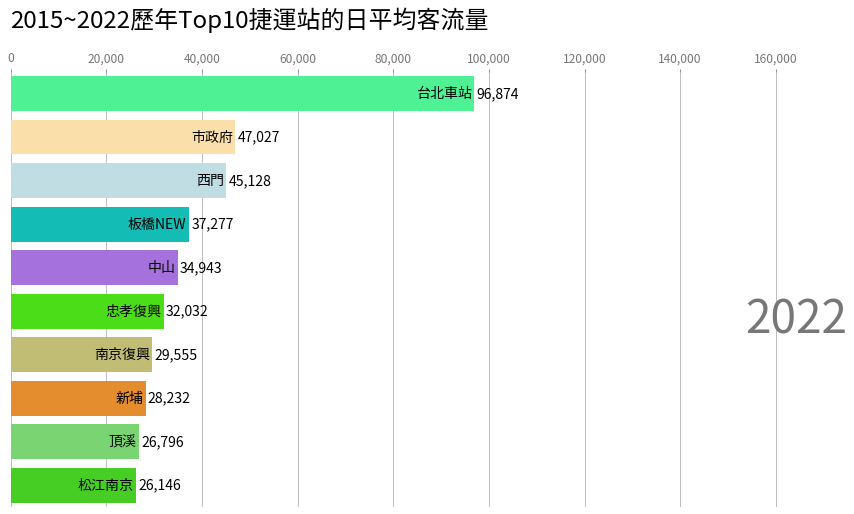

In [21]:
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML

def randomcolor():
    colorlist = ['1','2','3','4','5','6','7','8','9','A','B','C','D','E','F']
    color = [random.choice(colorlist) for _ in range(6)]
    return '#' + ''.join(color)

metro_list = exit_total.columns.tolist()
color_list = [randomcolor() for _ in range(len(metro_list))]
colors = dict(zip(metro_list, color_list))

fig, ax = plt.subplots(figsize=(15, 8))
def draw_barchart(year):
    top10 = exit_total[f'{year}'].mean().sort_values(ascending=True)[-10:]
    ax.clear()
    ax.barh(top10.index, top10, color = [colors[x] for x in top10.index])
    dx = top10.max()/200
    for i, (name, value) in enumerate(zip(top10.index, top10.values)):
        ax.text(value-dx, i, name, size=14, weight=600, ha='right', va='center')
        ax.text(value+dx, i, f'{value:,.0f}', size=14, ha='left', va='center')
    ax.text(0, 1.15,'2015~2022歷年Top10捷運站的日平均客流量', transform=ax.transAxes,size=24,weight=600,ha='left',va='top')
    ax.text(1, 0.4, year, transform=ax.transAxes, color='#777777', size=46, ha='right', weight=800)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))      # set_major_formatter表示刻度尺格式
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_xlim(0, 175000)
    ax.set_yticks([])
    ax.margins(0, 0.01)           # margins表示自动缩放余额
    ax.grid(which='major', axis='x', linestyle='-')        # 设置后面的网格
    ax.set_axisbelow(True)        # 刻度线和网格线是在图标上方还是下方，True为下方
    plt.box(False)
draw_barchart(2022)

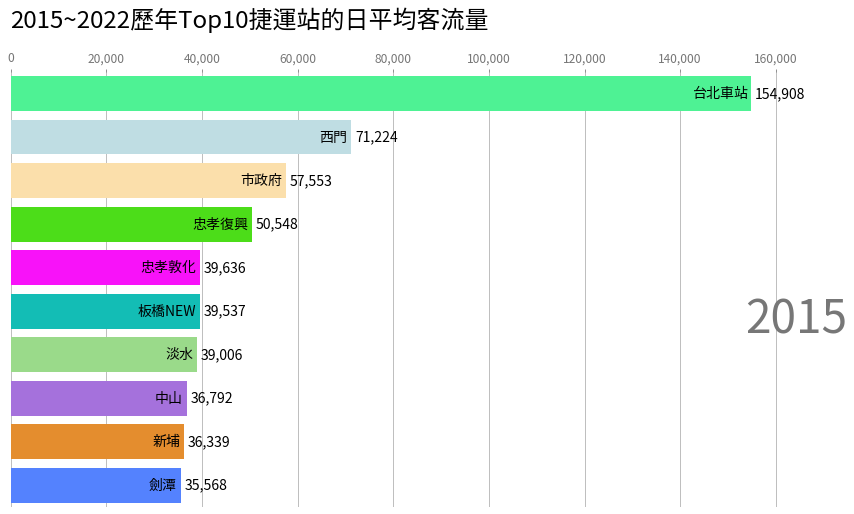

In [22]:
fig, ax = plt.subplots(figsize=(15, 8))
animator = animation.FuncAnimation(fig, draw_barchart, frames=range(2015, 2023))
HTML(animator.to_jshtml(fps=2))

In [ ]:
# writer = animation.PillowWriter(fps=2,
#                                 metadata=dict(artist='Crystal'),
#                                 bitrate=1800)
# animator.save('top10metro.gif', writer=writer)

### 3.5 出站客流量: 捷運路線分析

In [24]:
position = pd.read_csv('/content/drive/MyDrive/datasets/metro_pos.csv')
position[['x','y']] = position['座標'].str.split(',').apply(pd.Series)
position[['x','y']] = position[['x','y']].astype(int)
position.set_index('name', inplace=True)

years = list(exit_addfeature['年'].unique())
for i, year in enumerate(years):
    volumn = round(exit_total[f'{year}'].mean(), 1)
    volumn = pd.DataFrame(volumn, columns=[f'{year}'])
    position = pd.concat([position, volumn], axis=1)

In [25]:
year = '2022'
blue = position.loc[position['藍線']==1, year].sort_values(ascending=False)
green = position.loc[position['綠線']==1, year].sort_values(ascending=False)
orange = position.loc[position['橘線']==1, year].sort_values(ascending=False)
brown = position.loc[position['棕線']==1, year].sort_values(ascending=False)
red = position.loc[position['紅線']==1, year].sort_values(ascending=False)
yellow = position.loc[position['黃線']==1, year].sort_values(ascending=False)

Text(0, 0.5, '日平均客流量')

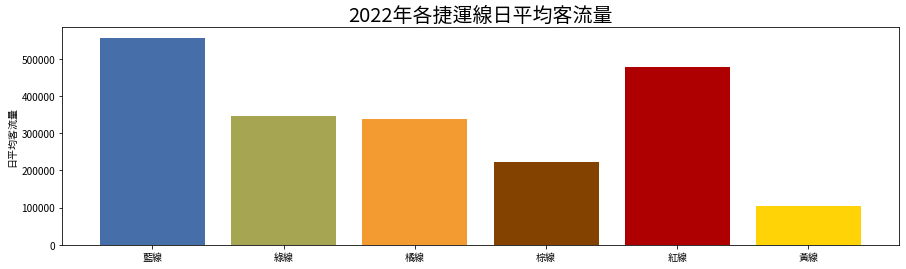

In [26]:
plt.figure(figsize=(15,4))
plt.bar(['藍線','綠線','橘線','棕線','紅線','黃線'], 
        [blue.sum(), green.sum(), orange.sum(), brown.sum(), red.sum(), yellow.sum()], 
        color=['#466FAA', '#A5A552', '#F39B30', '#844200', '#AE0000', '#FFD306'])
plt.title('2022年各捷運線日平均客流量', fontsize=20)
plt.ylabel('日平均客流量')

Text(0, 0.5, '日平均客流量')

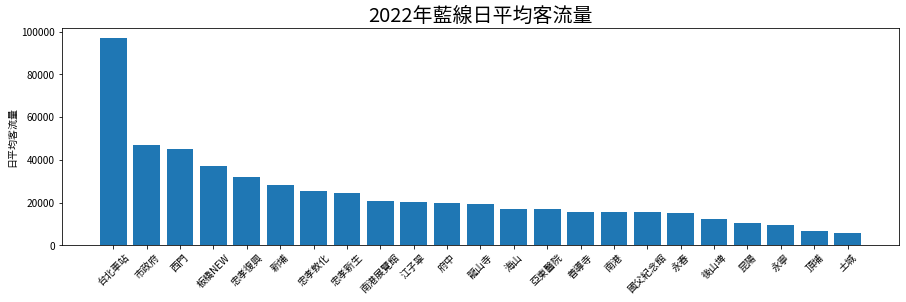

In [27]:
plt.figure(figsize=(15,4))
plt.xticks(rotation = 45)
plt.bar(blue.index, blue)
plt.title('2022年藍線日平均客流量', fontsize=20)
plt.ylabel('日平均客流量')

Text(0, 0.5, '日平均客流量')

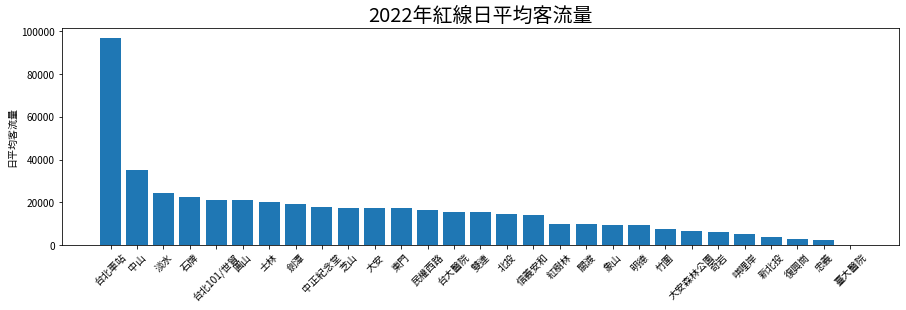

In [28]:
plt.figure(figsize=(15,4))
plt.xticks(rotation = 45)
plt.bar(red.index, red)
plt.title('2022年紅線日平均客流量', fontsize=20)
plt.ylabel('日平均客流量')

In [29]:
# !python3 -m pip install paddlepaddle==2.0.0 -i https://mirror.baidu.com/pypi/simple
# !pip install "paddleocr>=2.0.1"

In [30]:
# from paddleocr import PaddleOCR, draw_ocr
# from matplotlib import pyplot as plt 
# import cv2

# ocr_model = PaddleOCR(lang='ch', use_gpu=False)
# img_path = '/content/drive/MyDrive/datasets/metro.png'
# result = ocr_model.ocr(img_path)[0]   # Run the ocr method on the ocr model
# ocr_result = pd.DataFrame(result, columns=['box', 'metro'])
# ocr_result['name'] = ocr_result['metro'].apply(pd.Series)[0]
# def process(location):
#     p1, _, p2, _ = location
#     x1, y1 = p1
#     x2, y2 = p2
#     x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
#     return (x1,y1),(x2,y2)
# ocr_result['position'] = ocr_result['box'].apply(process)
# ocr_result.drop(columns=['box', 'metro'], axis=1, inplace=True)
# ocr_result.to_csv('ocr_result.csv', encoding='utf-8')
# ocr_result

In [31]:
position.iloc[:,-8:] = np.sqrt(position.iloc[:,-8:])
scaler = np.array(position.iloc[:,-8:]).max()/85
position.iloc[:,-8:] = (position.iloc[:,-8:]/scaler).astype(int)

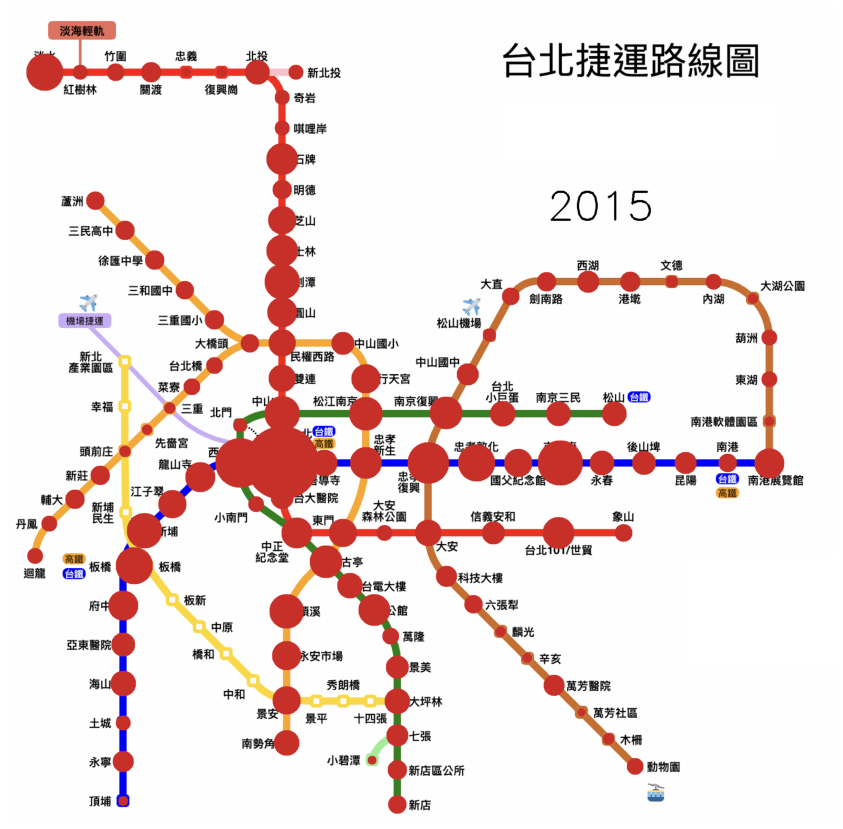

In [32]:
import cv2
img_path = '/content/drive/MyDrive/datasets/metro.png'    # 底圖來源於https://tw.piliapp.com/mrt-taiwan/taipei/ 
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
for x, y, r in zip(position['x'].values, position['y'].values, position['2015'].values):
    cv2.circle(img, (x, y), r, (199, 48, 40), -1)
cv2.putText(img, '2015', (1220, 482), 0, 3, (0, 0, 0), 4)
plt.figure(figsize=(15,15))
plt.imshow(img)
plt.xticks([]), plt.yticks([])
plt.box(False)

In [33]:
# 儲存成影片
video = cv2.VideoWriter('metroVolumn.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 1, (1872, 1842))
for year in range(2015, 2023):
    img = cv2.imread(img_path)
    for x, y, r in zip(position['x'].values, position['y'].values, position[f'{year}'].values):
        cv2.circle(img, (x, y), r, (40, 48, 199), -1)
    cv2.putText(img, f'{year}', (1220, 482), 0, 3, (0, 0, 0), 4)
    video.write(img)
video.release()

In [ ]:
!ffmpeg -i metroVolumn.mp4 -vcodec libx264 metroVolumn_final.mp4   # 檔案類型轉換，加上空的音軌

In [35]:
import base64
import IPython.display as dp
with open('metroVolumn_final.mp4', 'rb') as f:
    v = base64.b64encode(f.read()).decode()       # 將影片檔案轉成base64格式
dp.HTML(f'<video src="data:video/mp4;base64,{v}" width="800" controls />')   # 顯示影片播放器

### 3.6 進出站客流量對比分析
進站客流量反映了某個捷運站作為交通樞紐的重要性，以及該站周圍地區的人口密度。例如，如果一個捷運站的進站客流量很大，可能表示該站周圍有許多居民或商業區，並且該站扮演著重要的交通樞紐的角色。

出站客流量則反映了某個捷運站周圍地區的就業、教育、娛樂等設施的密度，以及該站周圍地區的旅遊需求。例如，如果一個捷運站的出站客流量很大，可能表示該站周圍有許多大型商業中心、學校、醫院等設施，或是該站周圍有許多旅遊景點。

In [36]:
exit_sum = exit_total.sum()
entry_sum = entry_total.sum()
rate = np.round(exit_sum/entry_sum, 2)
rate.sort_values(ascending=False, inplace=True)
head = rate.head(5)
tail = rate.tail(5)

In [37]:
head_new = pd.DataFrame(columns=['捷運站','進站客流量','出站客流量','出/進比例'])
name = head.index
head_new['捷運站'] = name
head_new['進站客流量'] = np.array(entry_sum[name])
head_new['出站客流量'] = np.array(exit_sum[name])
head_new['出/進比例'] = np.array(rate[name])
head_new

,捷運站,進站客流量,出站客流量,出/進比例
0,景平,2899042,3195714,1.10
1,幸福,2935328,3200885,1.09
2,新埔民生,1825982,1998065,1.09
3,國父紀念館,54820989,59465888,1.08
4,板橋NEW,111676199,119683389,1.07


In [38]:
tail_new = pd.DataFrame(columns=['捷運站','進站客流量','出站客流量','出/進比例'])
name = tail.index
tail_new['捷運站'] = name
tail_new['進站客流量'] = np.array(entry_sum[name])
tail_new['出站客流量'] = np.array(exit_sum[name])
tail_new['出/進比例'] = np.array(rate[name])
tail_new

,捷運站,進站客流量,出站客流量,出/進比例
0,亞東醫院,58460950,53029663,0.91
1,新店,34402572,30539458,0.89
2,奇岩,23446025,20122370,0.86
3,大橋頭,35593416,30043530,0.84
4,萬芳社區,6497082,5290980,0.81


Text(0.5, 1.0, 'Top 5 出站 < 進站')

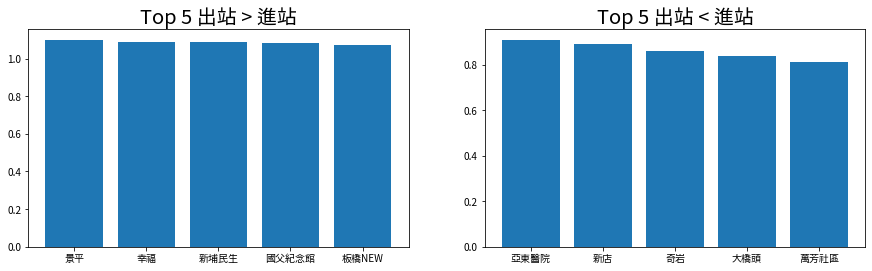

In [39]:
plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
plt.bar(head.index, head)
plt.title('Top 5 出站 > 進站', fontsize=20)

plt.subplot(1, 2, 2)
plt.bar(tail.index, tail)
plt.title('Top 5 出站 < 進站', fontsize=20)

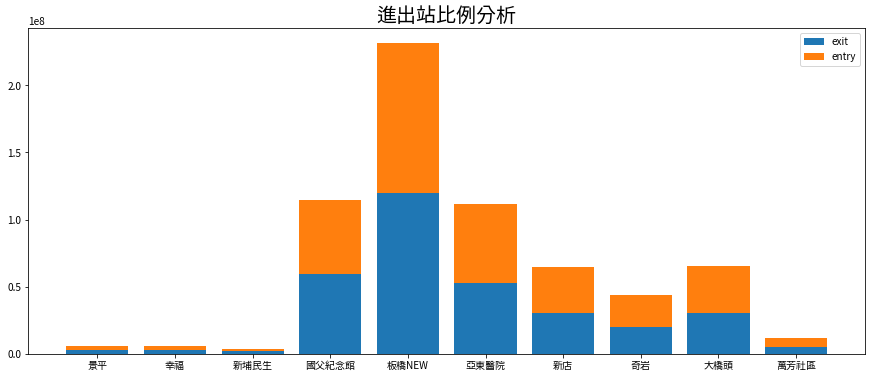

In [40]:
metroname = list(head.index) + list(tail.index)

plt.figure(figsize=(15,6))
plt.bar(metroname, exit_sum[metroname], label='exit')
plt.bar(metroname, entry_sum[metroname], bottom=exit_sum[metroname], label='entry')
plt.title('進出站比例分析', fontsize=20)
plt.legend()

## 四、預測未來客流量

### 4.1 預測客流量: 使用統計模型ARIMA

透過ETS將時間序列資料拆成：趨勢、季節性，可以看出客流量具有季節性。

(735599.0, 738521.0)

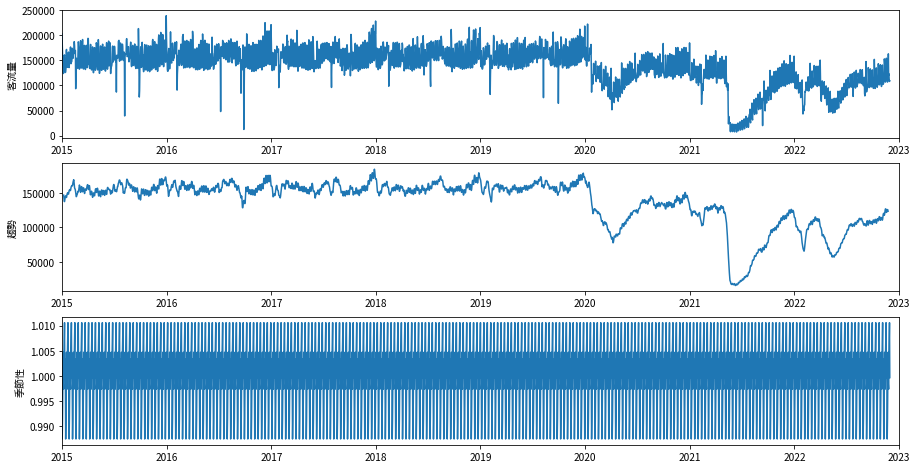

In [41]:
exit_taipeiStation = exit_addfeature['台北車站']
result = seasonal_decompose(exit_taipeiStation, model='multiplicative', freq=12)
plt.figure(figsize=(15,8))
plt.subplot(3,1,1)
plt.plot(result.observed)
plt.ylabel('客流量')
plt.xlim(np.datetime64('2015'), np.datetime64('2023'))

plt.subplot(3,1,2)
plt.plot(result.trend)
plt.ylabel('趨勢')
plt.xlim(np.datetime64('2015'), np.datetime64('2023'))

plt.subplot(3,1,3)
plt.plot(result.seasonal)
plt.ylabel('季節性')
plt.xlim(np.datetime64('2015'), np.datetime64('2023'))

時間序列的資料再跑統計模型前，先做平穩性檢驗，來判斷資料是否平穩(stationary)，如果不平穩，要做差分處理。因為Test Statistic > Criterical Value (10%)，不能拒絕原假設，也就是說序列是不平穩的，需要進一步做差分處理

In [42]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print("Results of Dickey-Fuller Test\n================================================")
    adf = adfuller(timeseries, autolag="AIC")
    output = pd.Series(adf[:4], index = [
        "Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key, value in adf[4].items():
        output["Criterical Value (%s)"%key] = value
    print(output)
    print("================================================")  
    #寫個自動判斷式
    if output[0] < output[4]:
        print("The data is stationary. (Criterical Value 1%)")  
    elif output[0] < output[5]:
        print("The data is stationary. (Criterical Value 5%)") 
    elif output[0] < output[6]:
        print("The data is stationary. (Criterical Value 10%)")
    else:
        print("The data is non-stationary, so do differencing!")
adf_test(exit_taipeiStation)

Results of Dickey-Fuller Test
Test Statistic                   -2.473636
p-value                           0.122021
#Lags Used                       28.000000
Number of Observations Used    2862.000000
Criterical Value (1%)            -3.432637
Criterical Value (5%)            -2.862550
Criterical Value (10%)           -2.567308
dtype: float64
The data is non-stationary, so do differencing!


Results of Dickey-Fuller Test
Test Statistic                -1.182506e+01
p-value                        8.240664e-22
#Lags Used                     2.700000e+01
Number of Observations Used    2.862000e+03
Criterical Value (1%)         -3.432637e+00
Criterical Value (5%)         -2.862550e+00
Criterical Value (10%)        -2.567308e+00
dtype: float64
The data is stationary. (Criterical Value 1%)


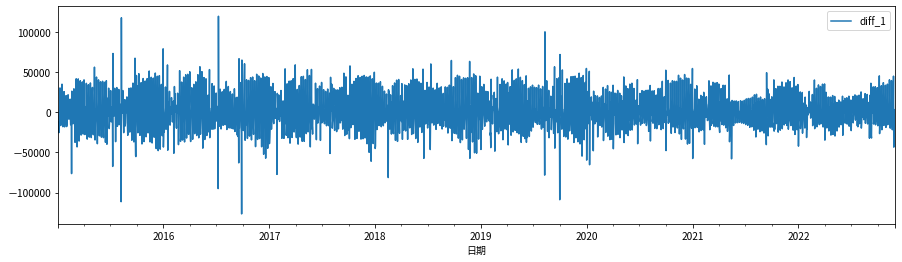

In [43]:
diff_1 = exit_taipeiStation.diff() 
diff_1 = diff_1.dropna()
diff_1.plot(figsize=(15,4), label='diff_1')
plt.legend()

adf_test(diff_1)

透過畫ACF(Autocorrelation Function)、PACF(Partial Autocorrelation Function)圖，輔助判斷模型ARIMA(p, d, q)參數的選擇

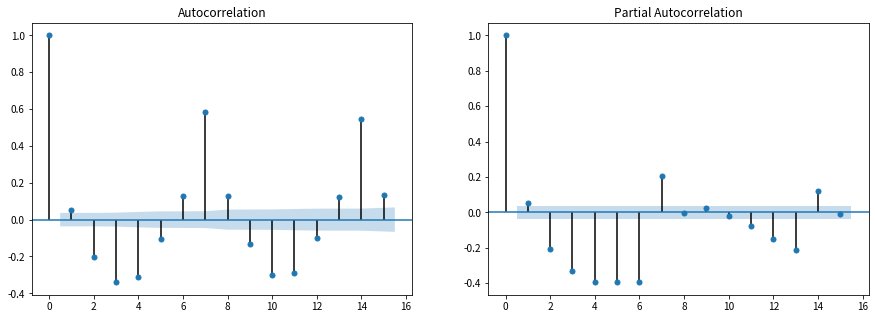

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
plot_acf(diff_1, lags=15, ax=ax1);
plot_pacf(diff_1, lags=15, ax=ax2);
plt.rcParams['axes.unicode_minus'] = False 
plt.show()

In [45]:
exit_taipeiStation2 = exit_taipeiStation.copy()
exit_taipeiStation2.index = pd.DatetimeIndex(exit_taipeiStation2.index).to_period('D')

In [46]:
order_aic_bic=[]
# Loop over p values from 0-2
for p in range(3):
  # Loop over q values from 0-2
    for q in range(3):
      	# create and fit ARMA(p,q) model
        model = ARIMA(exit_taipeiStation2, order=(p,1,q))
        results = model.fit()
        # Append order and results tuple
        order_aic_bic.append((p, q, results.aic, results.bic))
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, columns=['p', 'q', 'AIC', 'BIC'])
# Print order_df in order of increasing AIC
print(order_df.sort_values(by='AIC'))
# Print order_df in order of increasing BIC
print(order_df.sort_values(by='BIC'))  

   p  q           AIC           BIC
8  2  2  64054.674752  64090.488823
7  2  1  64391.162414  64421.007473
5  1  2  64636.742340  64666.587399
2  0  2  64712.972455  64736.848502
4  1  1  64869.787336  64893.663383
6  2  0  65334.620513  65358.496560
1  0  1  65452.979129  65470.886164
3  1  0  65457.358810  65475.265845
0  0  0  65463.183944  65475.121968
   p  q           AIC           BIC
8  2  2  64054.674752  64090.488823
7  2  1  64391.162414  64421.007473
5  1  2  64636.742340  64666.587399
2  0  2  64712.972455  64736.848502
4  1  1  64869.787336  64893.663383
6  2  0  65334.620513  65358.496560
1  0  1  65452.979129  65470.886164
0  0  0  65463.183944  65475.121968
3  1  0  65457.358810  65475.265845


In [47]:
model = ARIMA(exit_taipeiStation2, order=(2,1,2))
result = model.fit()
print(result.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.台北車站   No. Observations:                 2890
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -32021.337
Method:                       css-mle   S.D. of innovations          15690.172
Date:                Wed, 28 Dec 2022   AIC                          64054.675
Time:                        14:53:19   BIC                          64090.489
Sample:                    01-02-2015   HQIC                         64067.581
                         - 11-30-2022                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -17.5697     83.977     -0.209      0.834    -182.161     147.021
ar.L1.D.台北車站     1.1147      0.018     61.900      0.000       1.079       1.150
ar.L2.D.台北車站    -0.7459      0.022    -34.17

Text(0, 0.5, '出站客流量')

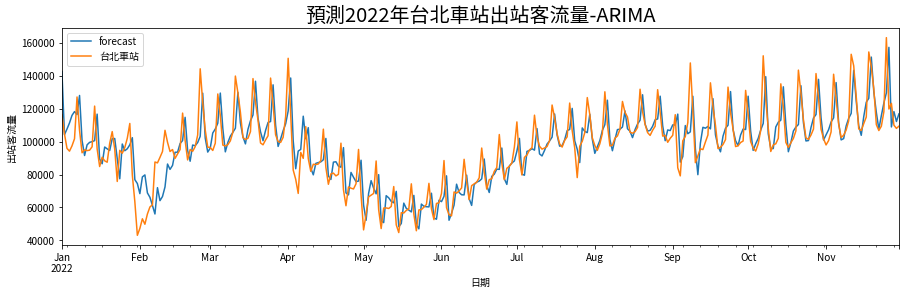

In [48]:
fig, ax = plt.subplots(figsize=(15,4))
result.plot_predict('2022-01-01', '2022-11-30', ax=ax)
plt.title('預測2022年台北車站出站客流量-ARIMA', fontsize=20)
plt.ylabel('出站客流量')

### 4.2 預測客流量: 使用神經網路模型Attention

In [49]:
import tensorflow as tf
import keras.backend as K

In [50]:
exit_taipeiStation = pd.read_csv('/content/drive/MyDrive/datasets/metro_exit_total.csv')
exit_taipeiStation['日期'] = pd.to_datetime(exit_taipeiStation['日期'])
exit_taipeiStation = exit_taipeiStation[['日期', '台北車站']]

s_date = np.datetime64('2022-01-01')
max_volumn = max(exit_taipeiStation['台北車站'])
train = exit_taipeiStation[exit_taipeiStation['日期'] <= s_date]['台北車站'].values
test = exit_taipeiStation[exit_taipeiStation['日期'] >= s_date]['台北車站'].values
test = test / max_volumn
train = train / max_volumn
LOOK_BACK = 6

x_train = np.array([train[k:k+LOOK_BACK] for k in range(len(train)-LOOK_BACK+1)])
y_train = np.array(train[LOOK_BACK-1:])
x_train = tf.reshape(x_train, (-1, LOOK_BACK, 1))
x_test = np.array([test[k:k+LOOK_BACK] for k in range(len(test)-LOOK_BACK+1)])
y_test = np.array(test[LOOK_BACK-1:])
x_test = tf.reshape(x_test, (-1, LOOK_BACK, 1))

In [51]:
class Attention(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        # input_shape: (bs, sequence len, feature dims)
        self.w = self.add_weight(name='attention_weight', shape=(input_shape[-1],1),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[1],1),
                                 initializer='zeros', trainable=True)        
        super().build(input_shape)
 
    def call(self, x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x, self.w) + self.b)
        alpha = tf.nn.softmax(e, axis=1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

inputs = tf.keras.layers.Input(shape=(LOOK_BACK, 1))
lstm_out = tf.keras.layers.LSTM(32, return_sequences=True)(inputs)
attention_out = Attention()(lstm_out)
outputs = tf.keras.layers.Dense(1)(attention_out)
# lstm_out = tf.keras.layers.LSTM(32)(inputs)
# outputs = tf.keras.layers.Dense(1)(lstm_out)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 lstm (LSTM)                 (None, 6, 32)             4352      
                                                                 
 attention (Attention)       (None, 32)                38        
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,423
Trainable params: 4,423
Non-trainable params: 0
_________________________________________________________________


In [52]:
epochs = 100
history = model.fit(x_train, y_train, epochs=epochs, batch_size=32, verbose=1)

Epoch 1/100
80/80 [==============================] - 3s 7ms/step - loss: 0.0635
Epoch 2/100
80/80 [==============================] - 1s 7ms/step - loss: 0.0112
Epoch 3/100
80/80 [==============================] - 0s 6ms/step - loss: 0.0111
Epoch 4/100
80/80 [==============================] - 0s 5ms/step - loss: 0.0108
Epoch 5/100
80/80 [==============================] - 0s 5ms/step - loss: 0.0106
Epoch 6/100
80/80 [==============================] - 1s 6ms/step - loss: 0.0105
Epoch 7/100
80/80 [==============================] - 1s 6ms/step - loss: 0.0102
Epoch 8/100
80/80 [==============================] - 0s 5ms/step - loss: 0.0100
Epoch 9/100
80/80 [==============================] - 0s 5ms/step - loss: 0.0097
Epoch 10/100
80/80 [==============================] - 0s 5ms/step - loss: 0.0095
Epoch 11/100
80/80 [==============================] - 1s 6ms/step - loss: 0.0092
Epoch 12/100
80/80 [==============================] - 0s 6ms/step - loss: 0.0089
Epoch 13/100
80/80 [=================

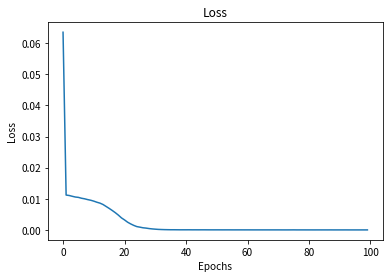

In [53]:
loss = history.history["loss"]
plt.figure()
plt.plot(range(epochs), loss)
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [54]:
y_pred = model.predict(x_test)
test_time = exit_taipeiStation[exit_taipeiStation['日期']>=s_date]['日期']
y_test *= max_volumn
y_pred *= max_volumn

11/11 [==============================] - 1s 2ms/step


Text(0, 0.5, '出站客流量')

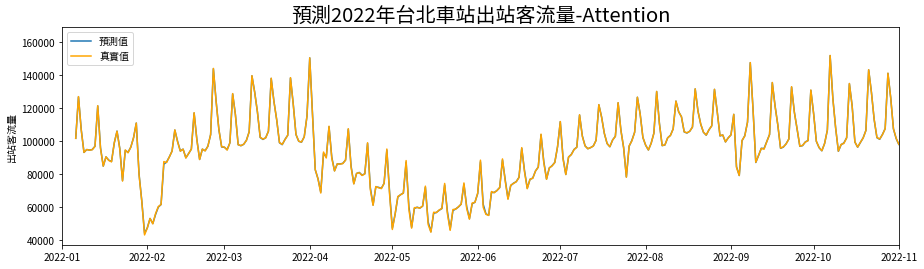

In [55]:
plt.figure(figsize=(15,4))
plt.plot(test_time[LOOK_BACK-1:], y_pred, label='預測值')
plt.plot(test_time[LOOK_BACK-1:], y_test, 'orange', label='真實值')
plt.xlim(np.datetime64('2022-01'), np.datetime64('2022-11'))
plt.legend()
plt.title('預測2022年台北車站出站客流量-Attention', fontsize=20)
plt.ylabel('出站客流量')

In [56]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)  
print('MAE:', round(mae,4))
print('MSE:', round(mse,4))
print('R2:', round(r2,4))

MAE: 214.5484
MSE: 120103.8512
R2: 0.9998


In [57]:
last6volumn = np.array(exit_taipeiStation.tail(LOOK_BACK)['台北車站']/max_volumn)
last6volumn = tf.reshape(last6volumn, (-1, LOOK_BACK, 1))
nextvolumn = model.predict(last6volumn) * max_volumn
print('預測2022年12月1日台北車站出站客流量為:', int(nextvolumn[0][0]))

1/1 [==============================] - 0s 17ms/step
預測2022年12月1日台北車站出站客流量為: 109591


## 五、結論
1. 本文主要透過趨勢分析、週期性分析了解客流量的長期趨勢和季節性，可以發現疫情前幾年，客流量長期處於逐年緩步上升的態勢。疫情確實給捷運帶來巨大的挑戰，後疫情時代捷運客流已經慢慢回到疫情前的水平。同時存在明顯的季節效應，在每年12月聖誕節和跨年晚會，人潮最多；2月農曆春節，運量來到低點。同時颱風和國定假日也會使得客流量明顯下降。

2. 此外，透過分析熱門捷運站點和捷運路線，發現人流主要聚集在藍線和紅線，以台北車站、市政府、西門、板橋等站點為代表，這些出站客流量大的站點，潛在的短程代步需求也會比較旺盛，可以輔助共享單車業者進行安置停車樁和車輛調度的決策依據。

3. 最後模擬股票技術方式的方式進行客流量異常偵測，及時警告異常狀態發生，從而輔助共享單車業者調整營運策略。並預測未來各捷運站點的客流量，其中以神經網路訓練處理的模型準確度可以達到99%，可以做為車輛調度的決策依據。